In [85]:
import pandas as pd
import numpy as np
import math

x_axis = []
loss_array = []

train_data = pd.read_csv('train.csv',encoding='big5')
# 取行和列的数据
data = train_data.iloc[:,3:]
data[data == "NR"] = 0
raw_data = data.to_numpy()
# 原始数据的shape:(4320, 24)
print('原始数据的shape:'+str(raw_data.shape))

#里面有12个月的数据，12*18*480
month_data = {}
for month in range(12):
    sample = np.empty([18,480])
    for day in range(20):
        # 每次循环需要填充18*24个数据
        sample[:,day*24:(day+1)*24] = raw_data[18*(20*month+day):18*(20*month+day+1),:]
    month_data[month] = sample

# 预处理阶段获取到最终的数据格式
# 为什么是471，其实是因为480的小时，每连续的9个小时可以组成一组数据，最后组成的数据就是471组
x = np.empty([12*471,18*9],dtype=float)
y = np.empty([12*471,1],dtype=float)

for month in range(12):
    for day in range(20):
        for hour in range(24):
            if day == 19 and hour > 14:
                # 终止处理数据
                continue
            x[month*471+day*24+hour,:] = month_data[month][:,day*24+hour:day*24+hour+9].reshape(1,-1)
            y[month*471+day*24+hour,0] = month_data[month][9,day*24+hour+9]   

# 有162=18*9个特征
# x.shape:(5652, 162)
# y.shape:(5652, 1)                                                                                  
print('x.shape:'+str(x.shape))
print('y.shape:'+str(y.shape)) 

# 数据归一化
mean_x = np.mean(x,axis=0)
std_x = np.mean(x,axis=0)
for i in range(len(x)):
    for j in range(len(x[0])):
        if std_x[j] != 0:
            x[i][j] = (x[i][j] - mean_x[j]) / std_x[j]
# 一共有18个特征，每个特征在9个小时里面的数据不同，最后一个数输出
# 162 + 1

# 梯度下降的方法使用adagrad,保留着梯度的平方项进行计算，
# loss函数用的平方差损失函数
# 定义训练的权重参数
dim = 18*9+1 # w+b方法放到了一个参数里面
w = np.zeros([dim,1])
print(x.shape)
x = np.concatenate((np.ones([12*471,1]),x),axis=1).astype(float)
print(x.shape)
learning_rate = 500
iter_time = 5000
adagrad = np.zeros([dim,1])
eps = 1e-10
for t in range(iter_time):
    loss = np.sqrt(np.sum(np.power(np.dot(x, w) - y, 2))/471/12)#rmse
    if (t%100==0):
        # print(str(t)+":"+str(loss))
        x_axis.append(t)
        loss_array.append(loss)
    gradient = 2*np.dot(x.transpose(),np.dot(x,w)-y)
    adagrad += gradient ** 2
    w = w - learning_rate * gradient / np.sqrt(adagrad + eps)
np.save('weight.npy', w)
print('训练结束！')


原始数据的shape:(4320, 24)
x.shape:(5652, 162)
y.shape:(5652, 1)
(5652, 162)
(5652, 163)
训练结束！


[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100]
[27.071214829194115, 36.77827526657392, 22.21872252252832, 16.926215576776197, 13.93016345537056, 11.921488442259253, 10.503171555148095, 9.480735595803345, 8.731466453836527, 8.17193152522892, 7.744993447492041, 7.4118436522277555]


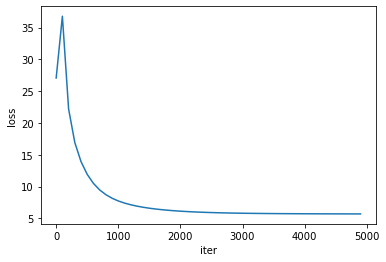

In [86]:
import matplotlib.pyplot as plt
print(x_axis[:12])
print(loss_array[:12])

fig,ax = plt.subplots()
ax.set_xlabel('iter')
ax.set_ylabel('loss')
ax.plot(x_axis,loss_array)


In [65]:
# 预测PM2.5
testdata = pd.read_csv('./test.csv', header = None, encoding = 'big5')
test_data = testdata.iloc[:, 2:]
test_data[test_data == 'NR'] = 0
test_data = test_data.to_numpy()
test_x = np.empty([240, 18*9], dtype = float)
for i in range(240):
    test_x[i, :] = test_data[18 * i: 18* (i + 1), :].reshape(1, -1)
for i in range(len(test_x)):
    for j in range(len(test_x[0])):
        if std_x[j] != 0:
            test_x[i][j] = (test_x[i][j] - mean_x[j]) / std_x[j]
test_x = np.concatenate((np.ones([240, 1]), test_x), axis = 1).astype(float)


In [67]:
w = np.load('weight.npy')
ans_y = np.dot(test_x, w)

In [68]:
import csv
with open('submit.csv', mode='w', newline='') as submit_file:
    csv_writer = csv.writer(submit_file)
    header = ['id', 'value']
    print(header)
    csv_writer.writerow(header)
    for i in range(240):
        row = ['id_' + str(i), ans_y[i][0]]
        csv_writer.writerow(row)
        print(row)

['id', 'value']
['id_0', 6.5944145339744455]
['id_1', 18.29966558054451]
['id_2', 23.289371632850973]
['id_3', 7.80251168578997]
['id_4', 27.114960602373703]
['id_5', 22.12375549963248]
['id_6', 23.790557872555873]
['id_7', 30.497068226098833]
['id_8', 16.985471316930674]
['id_9', 59.65762674011245]
['id_10', 11.564409905694033]
['id_11', 9.470265684003515]
['id_12', 63.92638661837445]
['id_13', 53.261429620743684]
['id_14', 22.098504305701862]
['id_15', 12.167819185840687]
['id_16', 32.472909612561736]
['id_17', 66.5029065318581]
['id_18', -0.5227090513755757]
['id_19', 17.220507372739743]
['id_20', 41.62968788950205]
['id_21', 72.1087956291079]
['id_22', 9.414286994315942]
['id_23', 17.58944935755808]
['id_24', 14.811186940598258]
['id_25', 37.67811395255819]
['id_26', 14.575781989011197]
['id_27', 69.93377539593055]
['id_28', 7.196819566877313]
['id_29', 55.25158677807841]
['id_30', 24.369660720726735]
['id_31', 8.498553149113803]
['id_32', 2.620008531440968]
['id_33', 18.8673020025